In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os, sys
main_dir = os.path.dirname(os.path.abspath(''))
sys.path.insert(0, main_dir)

import models.helper as hlp
from models.custom.model import *
import forward.fourier.method as fwd
from forward.fourier.kernel_creator import create_fourier_kernel

import gc
def clear_gpu():
    gc.collect()
    torch.cuda.empty_cache()


GPU_ID = 2
if torch.cuda.is_available():
    # torch.cuda.set_device(GPU_ID) # Select 5th GPU
    print(torch.cuda.device_count(), "GPU(s) available:")
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name(i))
else:
    print("No GPUs available.")


%load_ext autoreload
%autoreload 2

5 GPU(s) available:
NVIDIA GeForce RTX 3090
NVIDIA GeForce RTX 3090
NVIDIA GeForce RTX 3090
NVIDIA GeForce RTX 3090
NVIDIA GeForce RTX 3090


In [2]:
undisp_cube, mask, spectras = hlp.create_bs_data(desired_channels=21,interp_type='average') #here we'll work with synthetic data. 

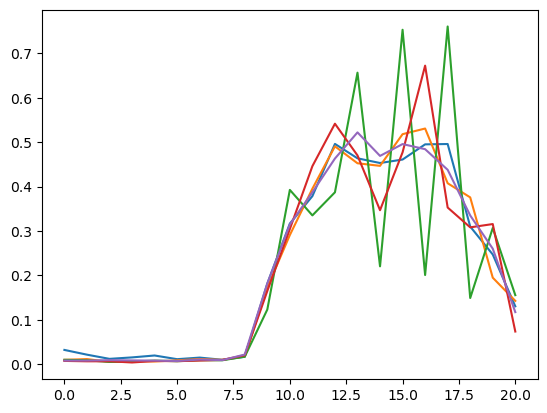

In [3]:
for i in range(0,2900,600):
    plt.plot(spectras[:,i].cpu().numpy(),label=str(i))

In [4]:
batch_size = 2
torch.cuda.empty_cache()


kernel = create_fourier_kernel().unsqueeze(0).permute(0,3,1,2).to('cuda')

dataset = hlp.SyntheticDataset(undispersed_cube=undisp_cube,shift_info={'kernel':kernel}, spectra = spectras)

allindexes = np.arange(len(dataset))
np.random.shuffle(allindexes)
tr_indexes = allindexes[:int(0.05*len(allindexes))]#np.array([[2281]])
v_indexes = allindexes[int(0.05*len(allindexes)):int(0.06*len(allindexes))] #np.array([[1135]])

# Create a data loader for batch processing
tr_loader = hlp.CustomDataLoader(dataset, tr_indexes, batch_size=batch_size, shuffle=True)
v_loader = hlp.CustomDataLoader(dataset, v_indexes, batch_size=batch_size, shuffle=True)

model = fourier_denoiser(mask=mask, kernel=kernel).to('cuda')

lr = 5e-4
epochs = 15


optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss = torch.nn.MSELoss()


history = hlp.train(model, optimizer, loss, tr_loader, v_loader, epochs=epochs, device='cuda')

torch.cuda.empty_cache()


train called: model=fourier_denoiser, opt=Adam(lr=0.000500), epochs=15, device=cuda

Epoch 1/15: (74/74), train loss: 0.0010786, val_loss = 0.00025127
Epoch 2/15: (74/74), train loss: 0.00024505, val_loss = 0.00024921
Epoch 3/15: (74/74), train loss: 0.00024397, val_loss = 0.00024762
Epoch 4/15: (74/74), train loss: 0.00021467, val_loss = 0.00014166
Epoch 5/15: (74/74), train loss: 8.1518e-05, val_loss = 5.9342e-05
Epoch 6/15: (74/74), train loss: 4.754e-05, val_loss = 4.6861e-05
Epoch 7/15: (74/74), train loss: 3.993e-05, val_loss = 4.2323e-05
Epoch 8/15: (74/74), train loss: 3.5861e-05, val_loss = 4.1159e-05
Epoch 9/15: (74/74), train loss: 3.3099e-05, val_loss = 3.5886e-05
Epoch 10/15: (74/74), train loss: 3.109e-05, val_loss = 3.6865e-05
Epoch 11/15: (74/74), train loss: 2.9699e-05, val_loss = 3.2849e-05
Epoch 12/15: (74/74), train loss: 2.9161e-05, val_loss = 3.6744e-05
Epoch 13/15: (74/74), train loss: 2.916e-05, val_loss = 3.1029e-05
Epoch 14/15: (74/74), train loss: 2.6881e-05,

Text(0, 0.5, 'log10(MSE)')

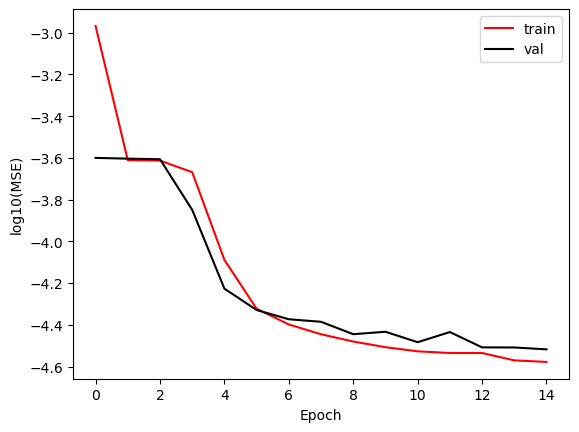

In [5]:
plt.plot(np.log10(history['loss']),'r',label = 'train')
plt.plot(np.log10(history['val_loss']),'k', label = 'val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('log10(MSE)')

In [6]:
# %%timeit

indexes = [600,1800]
(x,y) = dataset[indexes]
y_pred = model(x)

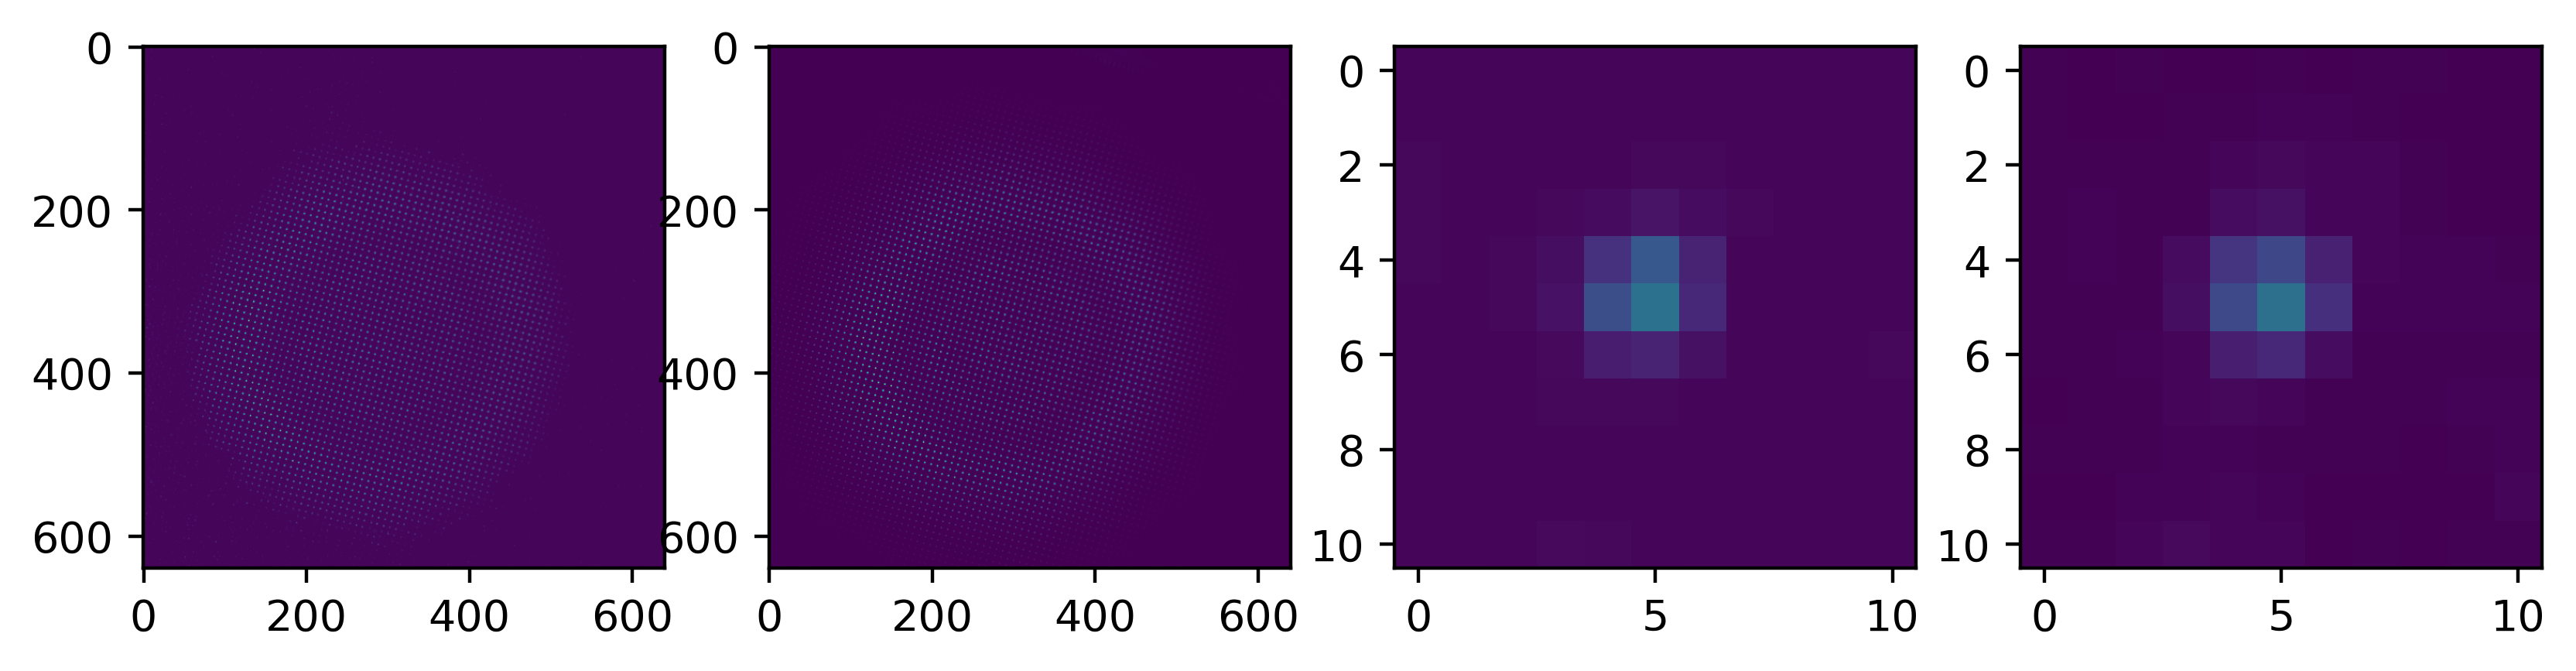

In [7]:
fig,ax = plt.subplots(1,4,figsize=(10,5),dpi=400)
ax[0].imshow(y_pred[0,10].cpu().detach().numpy())
ax[1].imshow(y[0,10].cpu().detach().numpy())

coords = [300,305]
boxsize = 5

ax[2].imshow(y_pred[0,10,coords[0]-boxsize:coords[0]+boxsize+1,coords[1]-boxsize:coords[1]+boxsize+1].cpu().detach().numpy(),vmax = y_pred[0,10].cpu().detach().numpy().max(),vmin = y_pred[0,10].cpu().detach().numpy().min())
ax[3].imshow(y[0,10,coords[0]-boxsize:coords[0]+boxsize+1,coords[1]-boxsize:coords[1]+boxsize+1].cpu().detach().numpy(),vmax = y[0,10].cpu().detach().numpy().max(),vmin = y[0,10].cpu().detach().numpy().min())

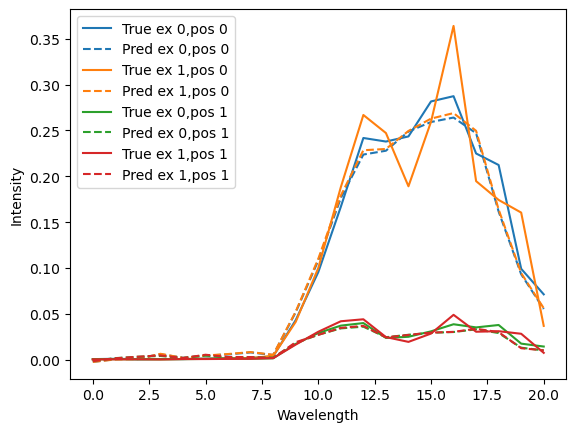

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
j=0
for i in range(2):
    # for j in range(2):
    for j in range(2):
        line, = ax.plot(y[j,:,coords[0]+i,coords[1]].cpu().detach().numpy(),label=   f'True ex {j},pos {i}')
        ax.plot(y_pred[j,:,coords[0]+i,coords[1]].cpu().detach().numpy(),color = line.get_color(),linestyle='--',label=   f'Pred ex {j},pos {i}')


ax.set_xlabel('Wavelength')
ax.set_ylabel('Intensity')
plt.legend()

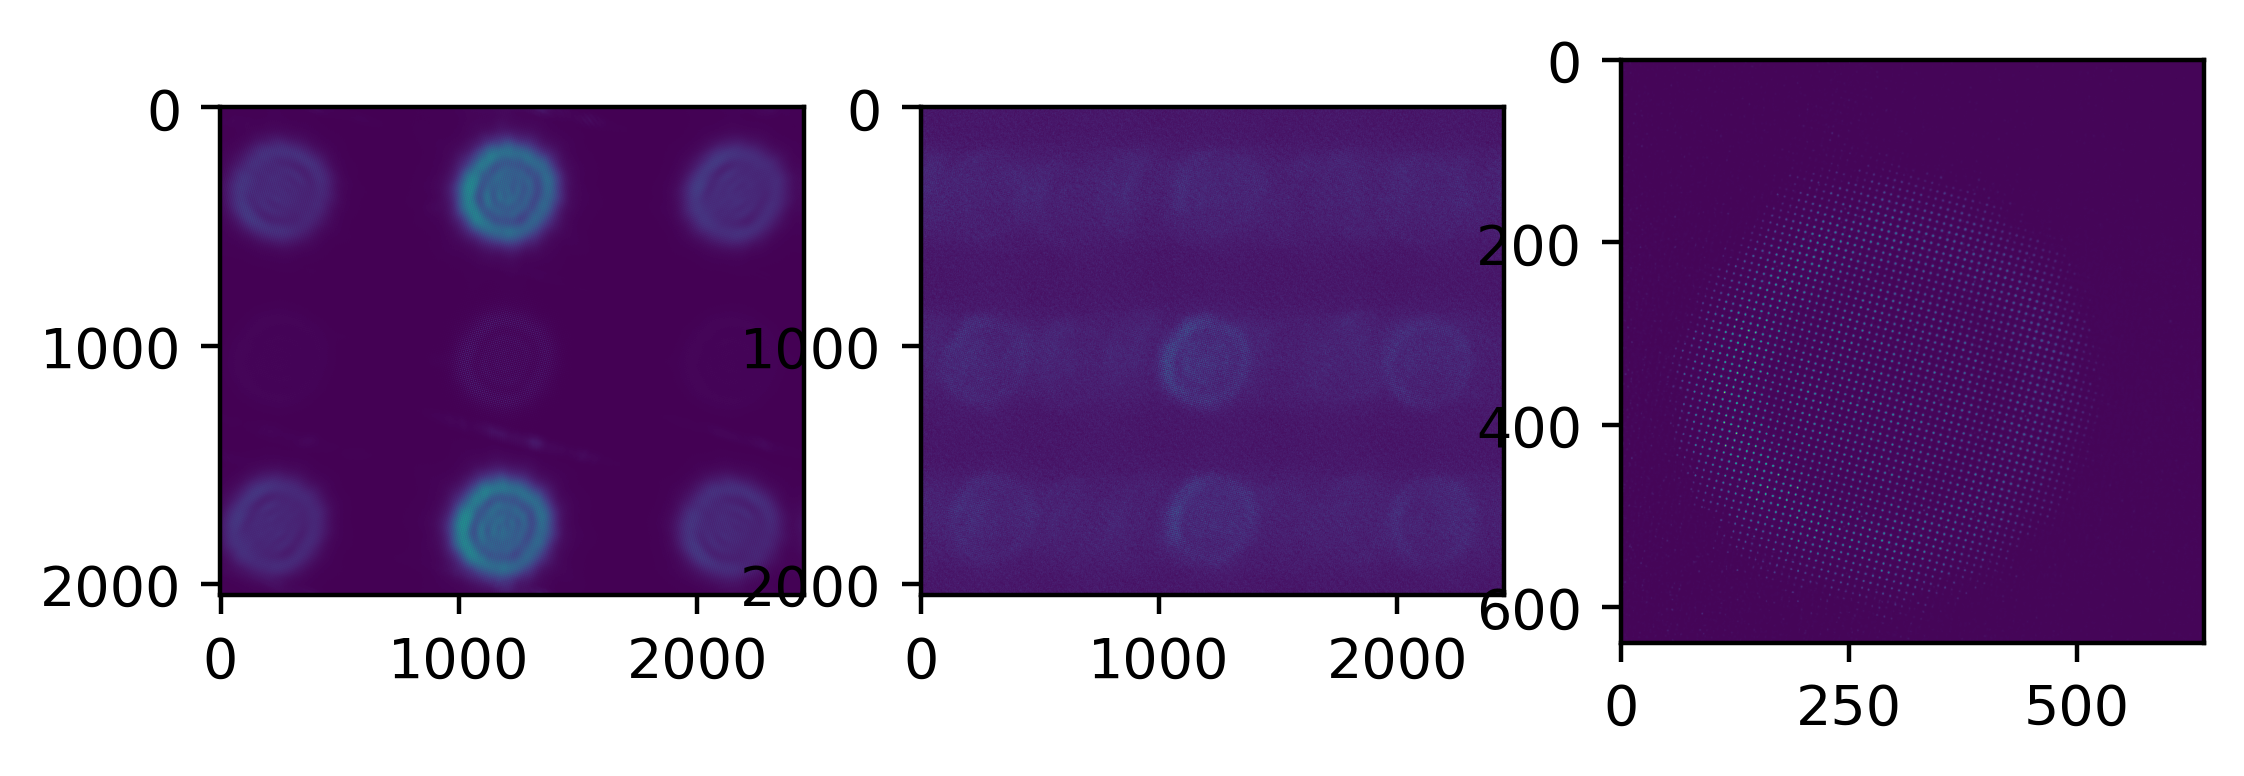

In [9]:
fig,ax = plt.subplots(1,3,dpi=400)
ax[0].imshow(x[0].cpu().detach().numpy())
ax[1].imshow(model.data_term(x)[0,10].cpu().detach().numpy())
ax[2].imshow(model(x)[0,10].cpu().detach().numpy())

In [10]:
torch.save(model.state_dict(), 'fourier_denoiser')